## Head on collision, claim estimation model

#### Extracting relevant data from xlsx training file:

In [1]:
#Data prepping:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer
#Models:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
#Neural model:
import torch
from torch import nn
from torch.nn import ReLU
from torch.utils.data import TensorDataset, DataLoader
#Testing / Visualizing models:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
#Reading in data, whilst dropping unnecessary columns:
hoc_df = pd.read_excel('head_on_collisions_data.xlsx', sheet_name='Data', usecols='C,F:AS')

#Printing original columns for clarity and to minimize risk of typo's in future:
print(hoc_df.columns)

Index(['Notifier', 'Notification_period', 'Inception_to_loss',
       'Location_of_incident', 'Weather_conditions', 'Vehicle_mobile',
       'Time_hour', 'Main_driver', 'PH_considered_TP_at_fault',
       'Vechile_registration_present', 'Incident_details_present',
       'Injury_details_present', 'TP_type_insd_pass_back',
       'TP_type_insd_pass_front', 'TP_type_driver', 'TP_type_pass_back',
       'TP_type_pass_front', 'TP_type_bike', 'TP_type_cyclist',
       'TP_type_pass_multi', 'TP_type_pedestrian', 'TP_type_other',
       'TP_type_nk', 'TP_injury_whiplash', 'TP_injury_traumatic',
       'TP_injury_fatality', 'TP_injury_unclear', 'TP_injury_nk',
       'TP_region_eastang', 'TP_region_eastmid', 'TP_region_london',
       'TP_region_north', 'TP_region_northw', 'TP_region_outerldn',
       'TP_region_scotland', 'TP_region_southe', 'TP_region_southw',
       'TP_region_wales', 'TP_region_westmid', 'TP_region_yorkshire',
       'Incurred'],
      dtype='object')


#### Turning descriptive data into numerical representations, within a formatted dataframe:
Encoding string entrys into integers that represent them, and the following special cases
    into arrays, with indexes representing the following descriptions:

<br>TP_Type*    -> [Insd_pass_back, Insd_pass_front, driver, pass_back, pass_front, 
                bike, cyclist, pass_multi, pedestrian]
<br>TP_Injury*  -> [whiplash, traumatic, fatality]
<br>TP_Region*  -> [eastang, eastmid, london, north, northw, outerldn, scotland, southe,
                southw, wales, westmid, yorkshire]

In [3]:
#Creating arrays to become columns of non-existant features (marked in * above)
tp_type_data = np.zeros((len(hoc_df.index),), dtype=int)
tp_injury_data = np.zeros((len(hoc_df.index),), dtype=int)
tp_region_data = np.zeros((len(hoc_df.index),), dtype=int)
    
#Turning string values into numerical representations where 0 = NaN/Unclear/not known, and other values are described below:
hoc_df['Vehicle_mobile'] = hoc_df['Vehicle_mobile'].map({"N":1, "Y":2}).fillna(0)
hoc_df['Main_driver'] = hoc_df['Main_driver'].map({"N":1,"Other":2,"Y":3}).fillna(0)
hoc_df['Notifier'] = hoc_df['Notifier'].map({"PH":1,"CNF":2,"TP":3,"NamedDriver":4}).fillna(0)
hoc_df['Location_of_incident'] = hoc_df['Location_of_incident'].map({"Main Road":1,"Minor Road":2,"Home Address":3,"Car Park":4, "Motorway":5}).fillna(0)
hoc_df['Weather_conditions'] = hoc_df['Weather_conditions'].map({"NORMAL":1,"WET":2,"SNOW,ICE,FOG":3}).fillna(0)
hoc_df['PH_considered_TP_at_fault'] = hoc_df['PH_considered_TP_at_fault'].map({"N":1, "Y":2}).fillna(0)

#### Printing head of data for clarity and to demonstrate structure:

In [4]:
#Making 'Incurred' is the final column for clarity
temporary_df = hoc_df.pop('Incurred')
hoc_df['Incurred'] = temporary_df

#Printing to demonstrate the format of the dataframe being used onwards:
print(hoc_df.iloc[0])

Notifier                         1.0
Notification_period             22.0
Inception_to_loss               13.0
Location_of_incident             1.0
Weather_conditions               1.0
Vehicle_mobile                   2.0
Time_hour                       10.0
Main_driver                      2.0
PH_considered_TP_at_fault        0.0
Vechile_registration_present     1.0
Incident_details_present         0.0
Injury_details_present           0.0
TP_type_insd_pass_back           0.0
TP_type_insd_pass_front          0.0
TP_type_driver                   0.0
TP_type_pass_back                0.0
TP_type_pass_front               0.0
TP_type_bike                     0.0
TP_type_cyclist                  0.0
TP_type_pass_multi               0.0
TP_type_pedestrian               0.0
TP_type_other                    0.0
TP_type_nk                       1.0
TP_injury_whiplash               0.0
TP_injury_traumatic              0.0
TP_injury_fatality               0.0
TP_injury_unclear                1.0
T

#### Using recursive feature elimination to rank features on their relationship to incurred price, to prune input:

In [5]:
#Splitting data and target
np.seterr(divide='ignore', invalid='ignore')
X = hoc_df.loc[:, hoc_df.columns.difference(['Incurred', 'TP_type','TP_injury','TP_region'])]
y = hoc_df['Incurred']

#Using recursive feature elimination to rank top features that are useful
selection = SelectKBest(score_func=f_regression, k = 10)
fittedKBest = selection.fit(X,y)

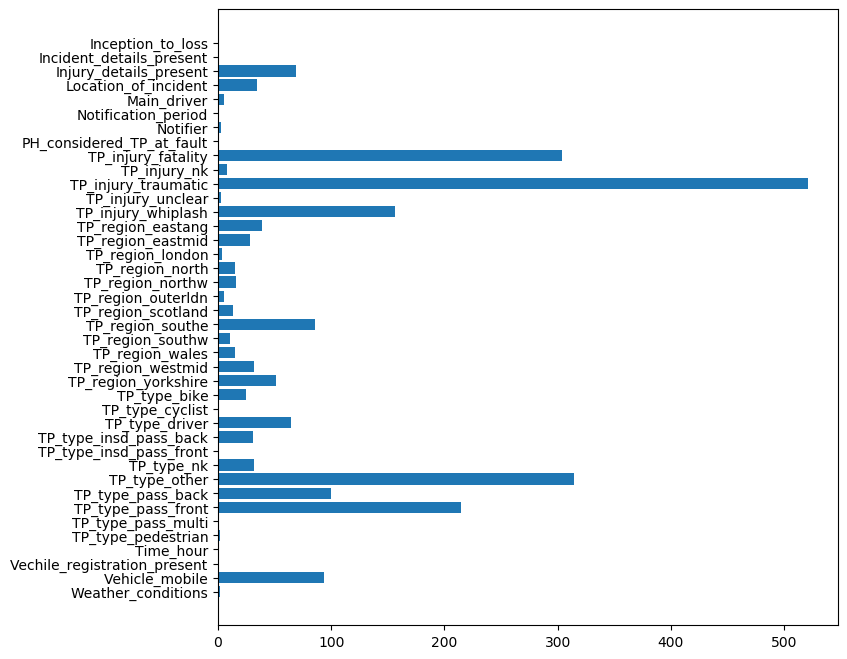

In [6]:
plt.rcdefaults()
fig, axis = plt.subplots(figsize=(8, 8))
columnsListed = X.columns.tolist()
axis.barh(columnsListed, fittedKBest.scores_, align = 'center')
axis.set_yticklabels(columnsListed)
axis.invert_yaxis()
plt.show()

Looking at the above data, it's clear that there are aprox 10 features that have useful correlations to the Incurred value- and thus these are the ones I'll include into my 'X' input data:

In [7]:
#Returning an array of ints, corresponding to indexes of columns chosen:
booleanSelection = selection.get_support()
indexes = np.where(booleanSelection)[0]

#Creating a 'new_X' dataframe with only these columns
new_X = pd.DataFrame()
for index in indexes:
    new_X[X.columns[index]] = X.iloc[:,index]

#Printing names of these columns (and their order) for future clarity:
print(new_X.columns)

Index(['Injury_details_present', 'TP_injury_fatality', 'TP_injury_traumatic',
       'TP_injury_whiplash', 'TP_region_southe', 'TP_type_driver',
       'TP_type_other', 'TP_type_pass_back', 'TP_type_pass_front',
       'Vehicle_mobile'],
      dtype='object')


#### Using this knowledge to train multiple models:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y)

#Standardizing data
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

def compareVisually(y_prediction, title_passed):    
    #Creating plot, and plotting data:
    f, ax = plt.subplots(figsize=(8, 3))
    plt.scatter(y_test, y_prediction)
    plt.axis('tight')
    plt.xlabel('True Incurred')
    plt.ylabel('Predicted Incurred')
    
    #Getting the min+max of y and x, to get a y=x line for clarity of relationship:
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    #Plotting the y=x line (in the background, with dotted line):
    ax.plot(lims, lims, 'k--', zorder=0)
    
    #Showing the graph with correct title, as well as accuracy score:
    print("Accuracy Score = ", r2_score(y_test,y_prediction))
    plt.title(title_passed)
    plt.show()

{'learning_rate': 0.01, 'n_estimators': 300}
Accuracy Score =  0.08345368250453167


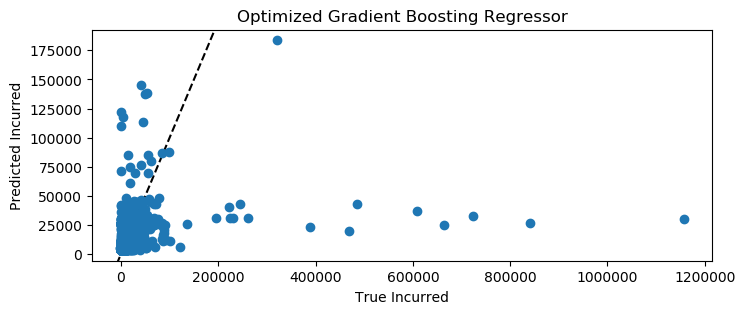

In [9]:
#Optimizing Gradient Boosting Regressor Model:
model_params = {
    'learning_rate': [0.1,0.01,0.001],
    'n_estimators': [100,200,300,400]
}
r2_scorer = make_scorer(r2_score)

#Grid Searching to find optimal parameters
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid = model_params, cv = 3, scoring = r2_scorer)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)

#Retraining and testing this model, for final results:
best_model = GradientBoostingRegressor(**grid_search.best_params_)
best_model.fit(X_train_scaled, y_train)
prediction = best_model.predict(X_test_scaled)
compareVisually(prediction, "Optimized Gradient Boosting Regressor")

{'n_neighbors': 58, 'weights': 'uniform'}
Accuracy Score =  0.07774948563462136


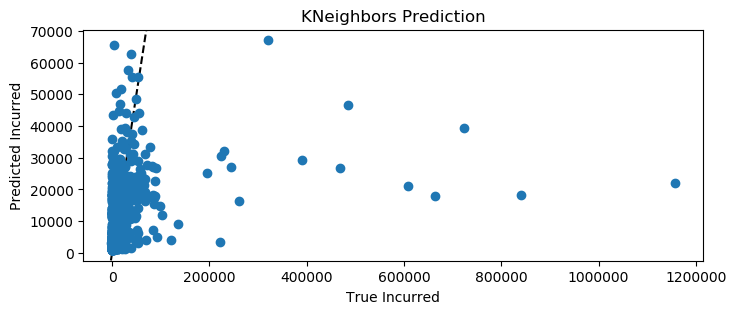

In [10]:
#KNeighbors Prediction:
model_params = {
    'n_neighbors': [52,54,56,58],
    'weights': ['uniform','distance']
}
r2_scorer = make_scorer(r2_score)

#Grid Searching to find optimal parameters
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid = model_params, cv = 3, scoring = r2_scorer)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)

#Retraining and testing this model, for final results:
best_model = KNeighborsRegressor(**grid_search.best_params_)
best_model.fit(X_train_scaled, y_train)
prediction = best_model.predict(X_test_scaled)
compareVisually(prediction, "KNeighbors Prediction")

In [11]:
#Neural Regressive Model:
class MultilayerRegressiveModel(nn.Module):
    def __init__(self, X, y):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(10,30),
            nn.ReLU(),
            nn.Linear(30,5),
            nn.ReLU(),
            nn.Linear(5,1)
        )
    def forward(self, x):
        return self.layers(x)
    
#Turning data into tensor dataset for a dataloader
X_torch_train = torch.tensor(X_train_scaled)
y_torch_train = torch.tensor(y_train.values)
X_torch_test = torch.tensor(X_test_scaled)
y_torch_test = torch.tensor(y_test.values)

#Prepping data
dataset = TensorDataset(X_torch_train, y_torch_train)
trainloader = torch.utils.data.DataLoader(dataset)

#Initalizing model
model = MultilayerRegressiveModel(X_torch_train, y_torch_train)
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

#Training loop:
for epoch in range(3):
    current_loss = 0
    for index, data in enumerate(trainloader,0):
        inputs, targets = data
        targets = targets.float().reshape((targets.shape[0], 1))
      
        #Forward pass:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        
        #Backward pass:
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

Accuracy Score =  0.007909953917236479


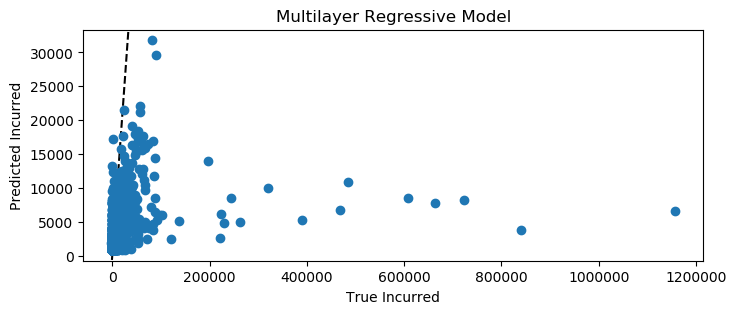

In [12]:
#Predicting and plotting
with torch.no_grad():
    prediction = model(X_torch_test.float())
    compareVisually(prediction, "Multilayer Regressive Model")

## Conclusion:
The best model performance (based on a coefficient of determination regression score function, the r2 metric from sklearn) is the simple Gradient Boosting Model. Despite this, looking at the graphs it appears that the Multilayer Regressive Model (or the KNN) follows the 'trend' (of true values) better and thus may be a stronger model, but for values of above (aprox.) 100,000 it drastically under-estimates and therefore it's r2 score is lower, so it's not as effective. I would recommend KNN or the Multilayer Regressive Models for smaller values despite the lower score.

### ----------------------------------------------------------------------------------------------------------------------------

#### Example of one-hot encoding that wasn't included:
Note: This isn't part of my solution however I am planning on discussing it during my 'suggestions for improvement' section during the presentation

In [13]:
#Reading in data, whilst dropping unnecessary columns:
hoc_df = pd.read_excel('head_on_collisions_data.xlsx', sheet_name='Data', usecols='C,F:AS')

'''Encoding string entrys into integers that represent them, and the following special cases
    into arrays, with indexes representing the following descriptions:

TP_Type*    -> [Insd_pass_back, Insd_pass_front, driver, pass_back, pass_front, 
                bike, cyclist, pass_multi, pedestrian]
TP_Injury*  -> [whiplash, traumatic, fatality]
TP_Region*  -> [eastang, eastmid, london, north, northw, outerldn, scotland, southe,
                southw, wales, westmid, yorkshire]
'''
#Creating arrays to become columns of non-existant features (marked in * above)
tp_type_data = np.zeros((len(hoc_df.index),), dtype=int)
tp_injury_data = np.zeros((len(hoc_df.index),), dtype=int)
tp_region_data = np.zeros((len(hoc_df.index),), dtype=int)

#Filtering all 'TP_injury','TP_region', and 'TP_type' columns into a single representative array:
filter_df_type = hoc_df.filter(axis=1, regex="TP_type.*")
filter_df_injury = hoc_df.filter(axis=1, regex="TP_injury.*")
filter_df_region = hoc_df.filter(axis=1, regex="TP_region.*")

hoc_df['TP_type'] = filter_df_type.values.tolist()
hoc_df['TP_injury'] = filter_df_injury.values.tolist()
hoc_df['TP_region'] = filter_df_region.values.tolist()

#Dropping the filtered (and no longer necessary) columns:
hoc_df = hoc_df.drop(filter_df_type.columns, axis=1)
hoc_df = hoc_df.drop(filter_df_injury.columns, axis=1)
hoc_df = hoc_df.drop(filter_df_region.columns, axis=1)

#Turning string values into numerical representations where 0 = NaN/Unclear/not known, and other values are described below:
hoc_df['Vehicle_mobile'] = hoc_df['Vehicle_mobile'].map({"N":1, "Y":2}).fillna(0)
hoc_df['Main_driver'] = hoc_df['Main_driver'].map({"N":1,"Other":2,"Y":3}).fillna(0)
hoc_df['Notifier'] = hoc_df['Notifier'].map({"PH":1,"CNF":2,"TP":3,"NamedDriver":4}).fillna(0)
hoc_df['Location_of_incident'] = hoc_df['Location_of_incident'].map({"Main Road":1,"Minor Road":2,"Home Address":3,"Car Park":4, "Motorway":5}).fillna(0)
hoc_df['Weather_conditions'] = hoc_df['Weather_conditions'].map({"NORMAL":1,"WET":2,"SNOW,ICE,FOG":3}).fillna(0)
hoc_df['PH_considered_TP_at_fault'] = hoc_df['PH_considered_TP_at_fault'].map({"N":1, "Y":2}).fillna(0)

#Making 'Incurred' is the final column for clarity
temporary_df = hoc_df.pop('Incurred')
hoc_df['Incurred'] = temporary_df

#Printing to demonstrate the format of the dataframe being used onwards:
print(hoc_df.iloc[0])

Notifier                                                           1
Notification_period                                               22
Inception_to_loss                                                 13
Location_of_incident                                               1
Weather_conditions                                                 1
Vehicle_mobile                                                     2
Time_hour                                                         10
Main_driver                                                        2
PH_considered_TP_at_fault                                          0
Vechile_registration_present                                       1
Incident_details_present                                           0
Injury_details_present                                             0
TP_type                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
TP_injury                                            [0, 0, 0, 1, 0]
TP_region                       [0